## Experiment Class Definition
- Helper class that defines the functions common to all model training(time series)

In [4]:
# %%writefile experiment.py
import numpy as np
import time
import torch
from torch import nn
from utils.timeserie import split_sequence
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import mlflow
#
from utils.ml import SimpleDataset, TransformerDataset
from utils.plot import plot_train_history, plot_predictions
from utils.m4 import deseasonalize, detrend, smape
# Transformers
from utils.ml import make_batches
from utils.plot import generate_square_subsequent_mask
#
class Experiment():

    def __init__(self, config: dict):
        # Set experiment config
        expected_vars = ['model','input_len','feature_dim','frequency',
                         'device','scaler','verbose','freq','decompose',
                         'forecast_horizon',]
        for v in expected_vars:
            assert v in config.keys(), f'Key "{v}" is missing on params dict'
        for k, v in config.items():
            vars(self)[k] = v
        self.config = config
        #
        # Pre-configuration (to produce same result in inference/predict)
        #
        np.random.seed(7); torch.manual_seed(7)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(7)
        #
        #
        #
        self.model = self.model.to(self.device)
        self.validation_dataset = None
        self.train_dataset = None

    def split_chunks(self, linear_serie, expand_dim=True):
        x, y = split_sequence(linear_serie, self.input_len)
        x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        if expand_dim:
            x, y = x.unsqueeze(-1), y.unsqueeze(-1)
        return x, y
    
    def ts_transform(self, ts, train=False):
        # de-sazonality
        if train: # calculate
            if self.verbose: print('Decomposition FIT')
            self.seasonality_in = deseasonalize(ts, self.freq)
        for i in range(0, len(ts)):
            ts[i] = ts[i] * 100 / self.seasonality_in[i % self.freq]

        # de-trending
        if train: # calculate
            self.a, self.b = detrend(ts)   
        for i in range(0, len(ts)):
            ts[i] = ts[i] - ((self.a * i) + self.b)
        
        return ts

    def ts_inverse_transform(self, ts):
        # add trend
        for i in range(0, len(ts)):
            ts[i] = ts[i] + ((self.a * i) + self.b)
        # add seasonality
        for i in range(0, len(ts)):
            ts[i] = ts[i] * self.seasonality_in[i % self.freq] / 100
        
        return ts
    
    def set_dataset(self, linear_serie, train=False, validation=False):
        linear_serie = linear_serie.copy()
        if self.decompose:
            linear_serie = self.ts_transform(linear_serie, train)

        if self.scaler is not None:
            if train: # FIT Scaler
                linear_serie = self.scaler.fit_transform(linear_serie.reshape(-1,1)).reshape(-1)
                if self.verbose: print('Scaler FIT')
                
            if validation:
                linear_serie = self.scaler.transform(linear_serie.reshape(-1,1)).reshape(-1)
        
        # transformer specific input shape
        if self.model.is_transformer():
            enc_x, dec_x, tgt_y = make_batches(linear_serie, 
                                               self.input_len, self.forecast_horizon)
            enc_x, dec_x, tgt_y = enc_x.to(self.device), dec_x.to(self.device), tgt_y.to(self.device)
            data = TransformerDataset(enc_x, dec_x, tgt_y)
        else: # naive, cnn, mlp, lstm, 
            x, y = self.split_chunks(linear_serie)
            x, y = x.to(self.device), y.to(self.device)
            data = SimpleDataset(x, y)
        # Save
        if train:
            self.train_dataset = data
        if validation:
            self.validation_dataset = data
        
        return data

    def train(self, train_conf):
        train_conf['train_dataset'] = self.train_dataset
        train_conf['validation_dataset'] = self.validation_dataset
        self.model.fit(train_conf)
    
    def train_history(self, offset=0):
        plot_train_history(self.model.train_loss_history, self.model.validation_loss_history, offset)
    
    def preprocess(self, ts): # from numpy to torch
        ts = np.asarray(ts, dtype=np.float32).copy()
        if self.decompose:
            ts = self.ts_transform(ts, train=False)
        if self.scaler is not None:
            ts = self.scaler.transform(ts.reshape(-1,1)).reshape(-1)
        ts = torch.tensor(ts, dtype=torch.float32)\
                                .view(1,-1, 1).to(self.device)
        return ts

    def posprocess(self, ts): # from torch to numpy
        ts = ts.to('cpu').detach().numpy()
        if self.scaler is not None:
            ts = self.scaler.inverse_transform(ts.reshape(-1,1)).reshape(-1)
        if self.decompose:
            ts = self.ts_inverse_transform(ts)
        # ts = ts.to(self.device)
        return ts.flatten()

    def predict(self, ts, forecast_horizon):
        # assert(len(ts) == self.input_len) 
        ts = self.preprocess(ts) # TODO add ts copy 
        output = self.model.predict(ts, forecast_horizon)
        # rescale and add trend, etc..
        output = self.posprocess(output)
        return output
    
    
    def print_metrics(self, real_y, pred_y):
        mape = mean_absolute_percentage_error(real_y, pred_y)
        err_smape = smape(real_y, pred_y)
        mse = mean_squared_error(real_y, pred_y)
        print(f'MSE: {mse:.4f} | MAPE: {mape:.4f} | sMAPE: {err_smape:.4f}')


---
#### Experiment Test (CNN)

#### Data Load

Proportion of train_set : 0.37%
Proportion of valid_set : 0.13%


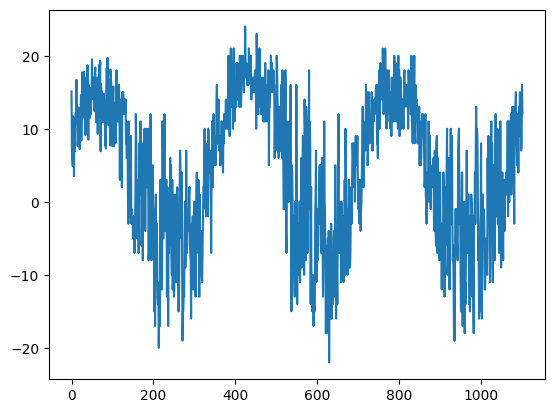

In [5]:
from utils.plot import plot_predictions
import matplotlib.pyplot as plt
import pandas as pd

solar_power = pd.read_csv('./data/solarpanelspower/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'date'}).set_index('date')

train_set = solar_power[:'2014-10-31']
valid_set = solar_power['2014-11-01':'2015-11-18']
# test_set = solar_power['2019-11-18':]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))
# print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(solar_power)))
plt.plot(train_set.Elec_kW.values)

#### Model

In [6]:
from models.cnn import SimpleCNN
from models.benchmark import NaivePredictor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
INPUT_LEN = 50
exp = Experiment(
    {
        # Model
        'model': SimpleCNN(INPUT_LEN, 64),
        'input_len':INPUT_LEN,
        'feature_dim':1,
        'forecast_horizon':1,
        # Data
        'frequency':'daily',
        'scaler':StandardScaler(),
        'decompose': True, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)

exp.train({
    'epochs':2,
    'lr':1e-3,#1e-5,
    'batch_size':512,
    'verbose':False,
})
fh = 100
last_train_values = train_set.Elec_kW.values[-INPUT_LEN:]
next_validation_values = valid_set.Elec_kW.values[:fh]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values, pred_y)
#
#
plot_predictions(train_set.Elec_kW.values, next_validation_values, pred_y)

Decomposition FIT
Scaler FIT
MSE: 45.0737 | MAPE: 0.4006 | sMAPE: 0.5113


In [ ]:
from utils.m4 import mase, smape
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# 

In [ ]:
# exp.train_history()

In [ ]:
target_x , target_y = split_sequence(train_set.Elec_kW.values,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)
inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')

model.eval()
model = model.to('cpu')
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]))
    prediction.append(preds.detach().numpy())
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()
